<a href="https://colab.research.google.com/github/JulianCL1997/Integrador-II/blob/main/Notebook_Sistema_Recomendador_Inteligente_de_Orientaci%C3%B3n_Vocacional_para_la_Selecci%C3%B3n_de_Carreras_Universitarias.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from __future__ import division

from scipy import stats
import numpy as np
from numpy import random
from numpy import matlib

import matplotlib.pyplot as plt
import pandas as pd
import math
import joblib

from sklearn.svm import SVC
from sklearn import metrics
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import CategoricalNB
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer

from mlxtend.feature_selection import SequentialFeatureSelector as SFS


from sklearn.model_selection import StratifiedKFold
import seaborn as sns
import time

#Algunas advertencias que queremos evitar
import warnings
warnings.filterwarnings("always")
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import ComplementNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import CategoricalNB



from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

## Carga y limpieza de datos

### Cargo mis datos y descarto las carreras que no usaremos


In [ ]:
#data = pd.read_csv("Datos Notebook.csv",delimiter=";",dtype="category")
data = pd.read_csv("Datos Notebook.csv",delimiter=";")
columnas = list(data)
print(data.iloc[:,0].value_counts())
data=data[data.iloc[:,0]!='Ingenieria Aeroespacial']
data=data[data.iloc[:,0]!='Ingenieria de Materiales']
data=data[data.iloc[:,0]!='Ingenieria Urbana']
print(data.iloc[:,0].value_counts())
print(len(data.iloc[:,0]))
dataset=data.copy()


Bioingenieria                       190
Ingenieria Industrial               145
Ingenieria de Sistemas              102
Ingenieria Electrica                 95
Ingenieria Mecanica                  95
Ingenieria Quimica                   81
Ingenieria Bioquimica                30
Ingenieria Ambiental                 21
Ingenieria Civil                     19
Ingenieria Electronica               18
Ingenieria Agroindustrial            16
Ingenieria Energetica                15
Ingenieria Sanitaria                  8
Ingenieria de Telecomunicaciones      8
Ingenieria de Materiales              3
Ingenieria Urbana                     3
Ingenieria Aeroespacial               1
Name: Carrera, dtype: int64
Bioingenieria                       190
Ingenieria Industrial               145
Ingenieria de Sistemas              102
Ingenieria Electrica                 95
Ingenieria Mecanica                  95
Ingenieria Quimica                   81
Ingenieria Bioquimica                30
Ingenieria A

### Etiquetamos los datos no numericos

In [ ]:
le = preprocessing.LabelEncoder()
le.fit(data.iloc[:,0])
print(le.classes_)
dataset=data.replace({"No":0,"Si":1,"Tal vez":2})
dat=le.transform(data.iloc[:,0])
dataset.iloc[:,0]=dat


['Bioingenieria' 'Ingenieria Agroindustrial' 'Ingenieria Ambiental'
 'Ingenieria Bioquimica' 'Ingenieria Civil' 'Ingenieria Electrica'
 'Ingenieria Electronica' 'Ingenieria Energetica' 'Ingenieria Industrial'
 'Ingenieria Mecanica' 'Ingenieria Quimica' 'Ingenieria Sanitaria'
 'Ingenieria de Sistemas' 'Ingenieria de Telecomunicaciones']


#### Revición visual de los datos


In [ ]:
dataset[0:15]

,Carrera,Te gustan los retos?,Afinidad Matematicas,Afinidad Fisica,Afinidad Quimica,Afinidad Ciencias Humanas,Afinidad Ciencias Naturales,Afinidad Ingenieria,interes por encontrar nuevos resultados experimentando,interes juegos de destreza mental,interes en aprovechar las oportunidades de mejora,Interes por el funcionamiento de las cosas,Gusto por trabajar solo,Que tan creativo,Te consideras un lider,Concentracion en actividades,autodidacta,orientacion vocacional dentro de tu institucion educativa,orientacion vocacional fuera de tu institucion educativa,atraido por el uso practico,Disfrutas estar mas con personas mayores,Que tan organizado,Apoyo de padres,que apoyado te sientes (padres),cuanto te gusta ense–ar,afinidad Desarmar cosas,Trabajo en equipo,Asimilacion textos,Te gusta el dibujo,maquetas o construccion,Lectura
0,12,5,4,4,1,1,1,5,5,5,5,5,5,3,1,5,1,0,0,1,2,4,1,5.0,5,4,1,4,3,4,1
1,12,5,5,4,1,3,2,5,5,5,5,5,4,4,1,3,2,0,0,1,2,4,1,5.0,5,5,1,3,1,4,0
2,12,4,4,1,1,2,3,5,4,4,4,4,3,4,0,3,2,0,0,1,0,3,1,5.0,2,4,1,4,4,3,1
3,12,5,3,1,1,4,2,4,4,5,5,5,4,4,1,3,1,0,0,2,2,2,1,4.0,2,4,1,3,2,1,1
4,12,5,5,5,4,3,4,5,5,5,5,5,5,5,1,5,1,0,0,2,1,3,1,5.0,5,5,1,4,2,3,1
5,12,5,4,4,3,5,3,5,2,3,5,5,2,4,1,5,1,1,1,1,1,4,1,5.0,5,5,0,4,5,4,1
6,12,3,4,2,1,4,3,3,5,5,5,4,4,3,0,3,2,2,0,1,1,2,1,4.0,5,1,1,4,2,2,1
7,12,5,5,3,1,1,1,5,3,5,4,5,3,5,1,4,2,0,0,1,2,3,1,5.0,3,3,1,1,2,3,0
8,12,4,3,4,2,4,4,4,4,3,5,4,4,4,1,3,2,1,0,1,1,3,2,2.0,4,5,1,4,3,2,1
9,12,5,4,2,2,2,2,5,3,5,4,4,3,5,1,4,2,0,0,1,1,5,1,5.0,4,3,1,4,5,4,1


In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 843 entries, 0 to 849
Data columns (total 31 columns):
 #   Column                                                     Non-Null Count  Dtype  
---  ------                                                     --------------  -----  
 0   Carrera                                                    843 non-null    int64  
 1   Te gustan los retos?                                       843 non-null    int64  
 2   Afinidad Matematicas                                       843 non-null    int64  
 3   Afinidad Fisica                                            843 non-null    int64  
 4   Afinidad Quimica                                           843 non-null    int64  
 5   Afinidad Ciencias Humanas                                  843 non-null    int64  
 6   Afinidad Ciencias Naturales                                843 non-null    int64  
 7   Afinidad Ingenieria                                        843 non-null    int64  
 8   interes po

In [ ]:
dataset.iloc[14:20,23]


14    5.0
15    NaN
16    5.0
17    5.0
18    4.0
19    5.0
Name: que apoyado te sientes (padres), dtype: float64

### Rellenamos los datos faltantes (datos nulos)



In [ ]:
#Separamos la columba
colum=dataset.iloc[:,23].copy()
#Sacamos la moda (valor mas repetido)
mode,_=stats.mode(colum)
#print(mode)
#remplazamos todas los valores Null por la moda
colum.fillna(mode[0],inplace=True)
#Cambiamos el tipo de dato para que todos sean el mismo tipo
#colum=colum.astype(pd.Int64Dtype())
#Guardamos la nueva columna en el data frame
dataset.iloc[:,23]=colum
#dataset=dataset.astype(pd.CategoricalDtype())
dataset=dataset.astype(pd.Int32Dtype())

#### Visualizamos la información despues de rellenar

In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 843 entries, 0 to 849
Data columns (total 31 columns):
 #   Column                                                     Non-Null Count  Dtype
---  ------                                                     --------------  -----
 0   Carrera                                                    843 non-null    Int32
 1   Te gustan los retos?                                       843 non-null    Int32
 2   Afinidad Matematicas                                       843 non-null    Int32
 3   Afinidad Fisica                                            843 non-null    Int32
 4   Afinidad Quimica                                           843 non-null    Int32
 5   Afinidad Ciencias Humanas                                  843 non-null    Int32
 6   Afinidad Ciencias Naturales                                843 non-null    Int32
 7   Afinidad Ingenieria                                        843 non-null    Int32
 8   interes por  encontrar nuevos 

In [ ]:
data=dataset
Y=pd.DataFrame(dat)
X=dataset.iloc[:,1:]
print(dataset.iloc[14:20,23])
print(X.shape)
# print(Y.shape)
print(type(dataset))
print(type(X))
print(type(Y))

14    5
15    5
16    5
17    5
18    4
19    5
Name: que apoyado te sientes (padres), dtype: Int32
(843, 30)
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


### Smote para datos sinteticos

In [ ]:
from collections import Counter
# Y2=Y.loc[pos, :]
# X2=X.loc[pos, :]
Y2=Y.copy()
X2=X.copy()

print(Y2.value_counts())
# counter = Counter(Y2)
# print(counter)

0     190
8     145
12    102
9      95
5      95
10     81
3      30
2      21
4      19
6      18
1      16
7      15
13      8
11      8
dtype: int64


In [ ]:
from imblearn.over_sampling import SMOTE
print(type(X2))
print(type(Y2))
oversample = SMOTE(kind='regular',k_neighbors=7)
X3, Y3 = oversample.fit_resample(X2, Y2)
print(Counter(Y3))
print(Y3.shape)
print(X3.shape)

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
Counter({12: 190, 8: 190, 5: 190, 7: 190, 10: 190, 0: 190, 6: 190, 2: 190, 4: 190, 11: 190, 9: 190, 3: 190, 1: 190, 13: 190})
(2660,)
(2660, 30)


/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

###Busqueda de modelos

In [ ]:
N = np.size(X3,0)
random.seed(1)
ind=np.random.permutation(N)
Xtrain = X3[ind[0:int(math.ceil(0.7*N))],:]
#separamos los datos del modelo
Xtest = X3[ind[int(math.ceil(0.7*N)):N],:]
print(Xtrain.shape)
#usaremos los train para entrenar y validar inicialmente el modelo
Ytrain = Y3[ind[0:int(math.ceil(0.7*N))]]
Ytest= Y3[ind[int(math.ceil(0.7*N)):N]]
#usaremos un kfolds en los test para validar el modelo con datos que nunca ha visto
dataSet1=[Xtrain,Ytrain,Xtest,Ytest]

(1862, 30)


In [ ]:
def error_score (y_true,y_pred):
  error=1-accuracy_score(y_true,y_pred)
  return error

def GridSearch(modelo,param,dataSet,plot=True):
  tiempo_i=time.time()
  #mean_score_time
  scoring={
      'accuracy':make_scorer(accuracy_score),
      'error':make_scorer(error_score),
      'f1':make_scorer(f1_score,average='weighted'),     
      'precision':make_scorer(precision_score,average='weighted'),
      
  }
  skf = StratifiedKFold(n_splits=10)
  clf = GridSearchCV(modelo,param_grid=param, n_jobs=4, cv=skf,scoring=scoring,refit="accuracy")
  clf.fit(dataSet[0],dataSet[1])

  best=clf.best_estimator_
  error=np.zeros(10)
  
  f1=np.zeros(10)
  precision=np.zeros(10)
 
  accuracy=np.zeros(10)
  i=0
  ytrue=[]
  ypred=[]
  for train, test in skf.split(dataSet[2], dataSet[3]):
    x_test = dataSet[2][test]
    y_test = dataSet[3][test]
    y_pred=best.predict(x_test)
    accuracy[i]=accuracy_score(y_test, y_pred)
    error[i]=1-accuracy_score(y_test, y_pred)
    f1[i]=f1_score(y_test,y_pred,average='weighted')
    
   
    precision[i]=precision_score(y_test, y_pred,average='weighted')
    i=i+1
  if(plot):
    print("Mejor modelo entrando", clf.best_params_)  
    print("F1: %0.5f (+/- %0.5f " %((np.mean(f1)),np.std(f1)))
    print("Exactitud: %0.5f (+/- %0.5f) "%((np.mean(precision)),np.std(precision)))
    print("Accuracy: %0.5f (+/- %0.5f) "%(np.mean(accuracy),np.std(accuracy)))
    print("Error: %0.5f (+/- %0.5f) "%(np.mean(error),np.std(error)))


    fig, ax = plt.subplots(figsize=(20, 20))
    plot_confusion_matrix(best,dataSet[2],dataSet[3],cmap=plt.cm.Blues,normalize='true',values_format='.5g',ax=ax)
    plt.show()

    print("tiempo de ejecucion", time.time()-tiempo_i)
  
  metricas=[np.mean(f1),np.std(f1),np.mean(precision),np.std(precision),np.mean(accuracy),np.std(accuracy),np.mean(error),np.std(error)]

  
  return clf,best,metricas

###Random Forest

Random Forest
Mejor modelo entrando {'criterion': 'gini', 'n_estimators': 200}
F1: 0.87244 (+/- 0.03105 
Exactitud: 0.88241 (+/- 0.03227) 
Accuracy: 0.87842 (+/- 0.02811) 
Error: 0.12158 (+/- 0.02811) 


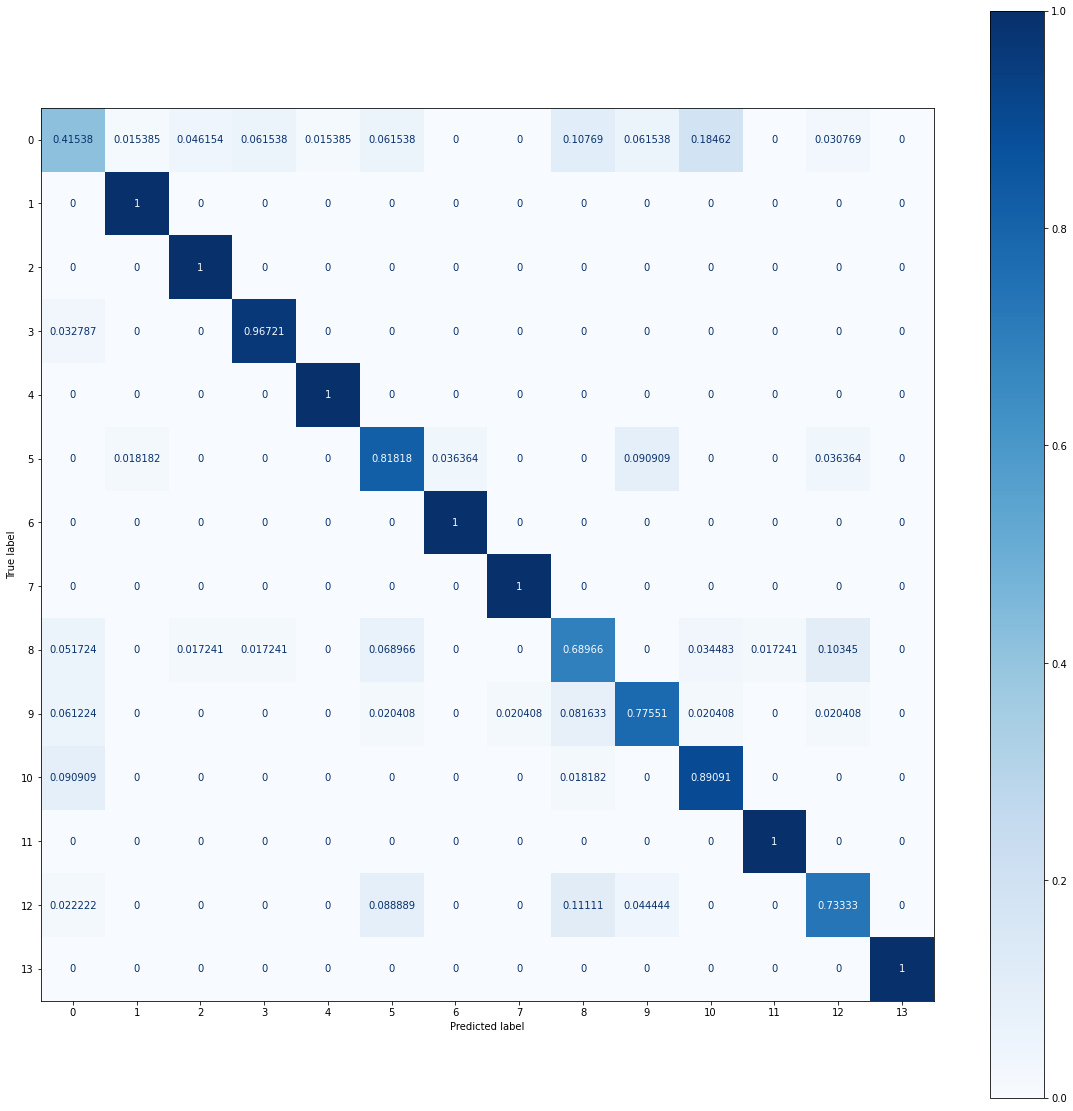

tiempo de ejecucion 128.4443814754486


,params,mean_test_accuracy,std_test_accuracy,mean_test_error,std_test_error,mean_test_precision,std_test_precision,rank_test_accuracy,rank_test_precision,mean_fit_time,std_fit_time,mean_score_time,std_score_time
0,"{'criterion': 'gini', 'n_estimators': 5}",0.661667,0.030446,0.338333,0.030446,0.668400,0.036486,17,18,0.086568,0.029802,0.010754,0.005665
1,"{'criterion': 'gini', 'n_estimators': 10}",0.733123,0.027589,0.266877,0.027589,0.732164,0.032218,15,16,0.181602,0.041872,0.012050,0.004434
2,"{'criterion': 'gini', 'n_estimators': 20}",0.789489,0.027050,0.210511,0.027050,0.790487,0.025998,13,13,0.335907,0.035025,0.016537,0.003140
3,"{'criterion': 'gini', 'n_estimators': 30}",0.815255,0.026228,0.184745,0.026228,0.808051,0.027336,12,12,0.517926,0.004340,0.019825,0.004047
4,"{'criterion': 'gini', 'n_estimators': 50}",0.832439,0.025857,0.167561,0.025857,0.830216,0.028220,9,9,0.865889,0.035802,0.028947,0.004399
5,"{'criterion': 'gini', 'n_estimators': 75}",0.849626,0.025718,0.150374,0.025718,0.845170,0.031423,5,6,1.285491,0.005410,0.039673,0.003657
6,"{'criterion': 'gini', 'n_estimators': 100}",0.848577,0.020414,0.151423,0.020414,0.847029,0.025815,6,5,1.698315,0.015351,0.051416,0.004054
7,"{'criterion': 'gini', 'n_estimators': 200}",0.858757,0.018577,0.141243,0.018577,0.856471,0.021214,1,1,3.406833,0.040615,0.089467,0.004496
8,"{'criterion': 'gini', 'n_estimators': 300}",0.856086,0.025059,0.143914,0.025059,0.852978,0.030559,3,3,5.041064,0.049197,0.131427,0.005318
9,"{'criterion': 'entropy', 'n_estimators': 5}",0.654681,0.032424,0.345319,0.032424,0.668943,0.032155,18,17,0.229884,0.014248,0.009838,0.004598


In [ ]:
param = {
          'n_estimators': [5,10,20,30,50,75,100,200,300],  
          'criterion': ['gini', 'entropy']
       
        } 
        
print("Random Forest")
model=RandomForestClassifier()
gs,RF,metricas=GridSearch(model,param,dataSet1)
dataFrame=pd.DataFrame(gs.cv_results_)
dataFrame[[ "params","mean_test_accuracy","std_test_accuracy","mean_test_error","std_test_error",
           "mean_test_precision","std_test_precision","rank_test_accuracy",
           "rank_test_precision","mean_fit_time","std_fit_time","mean_score_time","std_score_time"
           ]]

### Gradient Boosting Classifier

Gradient Boosting Classifier
Mejor modelo entrando {'loss': 'deviance', 'n_estimators': 100}
F1: 0.77470 (+/- 0.03672 
Exactitud: 0.79620 (+/- 0.03148) 
Accuracy: 0.77706 (+/- 0.03690) 
Error: 0.22294 (+/- 0.03690) 


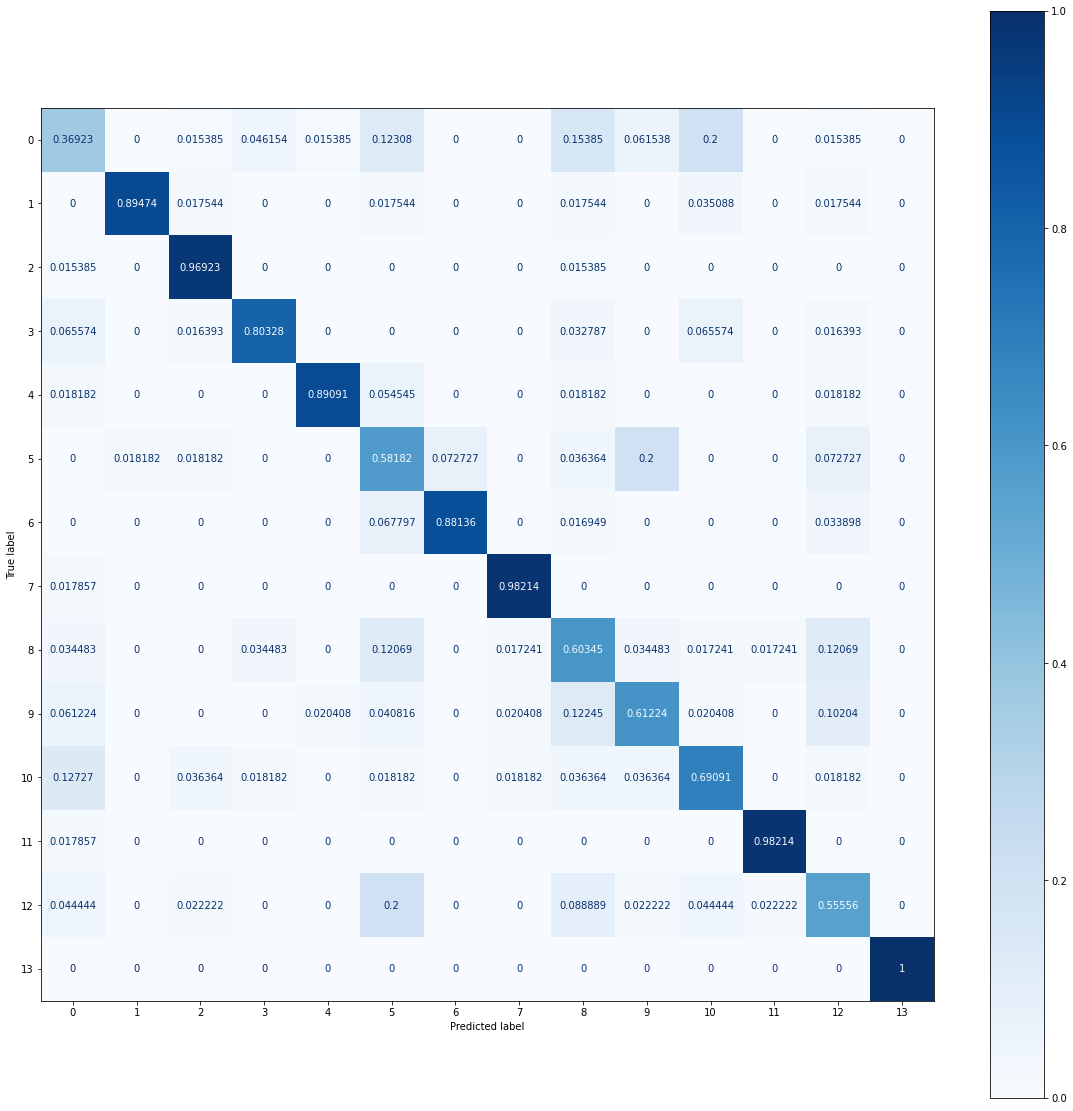

tiempo de ejecucion 328.95039772987366


,params,mean_test_accuracy,std_test_accuracy,mean_test_error,std_test_error,mean_test_precision,std_test_precision,rank_test_accuracy,rank_test_precision,mean_fit_time,std_fit_time,mean_score_time,std_score_time
0,"{'loss': 'deviance', 'n_estimators': 5}",0.528446,0.025573,0.471554,0.025573,0.506256,0.036535,7,7,1.918190,0.029912,0.008553,0.003399
1,"{'loss': 'deviance', 'n_estimators': 10}",0.577882,0.025728,0.422118,0.025728,0.554859,0.037089,6,6,3.802101,0.080488,0.009431,0.003159
2,"{'loss': 'deviance', 'n_estimators': 20}",0.648240,0.018860,0.351760,0.018860,0.637709,0.019871,5,5,7.603128,0.045416,0.012702,0.002790
3,"{'loss': 'deviance', 'n_estimators': 30}",0.687430,0.019966,0.312570,0.019966,0.678464,0.024371,4,4,13.046418,0.999102,0.018087,0.004199
4,"{'loss': 'deviance', 'n_estimators': 50}",0.726105,0.017071,0.273895,0.017071,0.721881,0.019734,3,3,23.080998,0.556896,0.024385,0.003632
5,"{'loss': 'deviance', 'n_estimators': 75}",0.754034,0.016701,0.245966,0.016701,0.756455,0.014430,2,2,33.303522,0.567813,0.026655,0.001929
6,"{'loss': 'deviance', 'n_estimators': 100}",0.762621,0.020356,0.237379,0.020356,0.766432,0.018630,1,1,39.249322,5.622356,0.022856,0.006796
7,"{'loss': 'exponential', 'n_estimators': 5}",NaN,NaN,NaN,NaN,NaN,NaN,8,8,0.001384,0.000155,0.000000,0.000000
8,"{'loss': 'exponential', 'n_estimators': 10}",NaN,NaN,NaN,NaN,NaN,NaN,9,9,0.001384,0.000970,0.000000,0.000000
9,"{'loss': 'exponential', 'n_estimators': 20}",NaN,NaN,NaN,NaN,NaN,NaN,10,10,0.001059,0.000043,0.000000,0.000000


In [ ]:
param = {
    
    'loss':['deviance', 'exponential'],
          'n_estimators': [5,10,20,30,50,75,100],  
          
        } 
        
print("Gradient Boosting Classifier")
model=GradientBoostingClassifier()
gs,RF,metricas=GridSearch(model,param,dataSet1)
dataFrame=pd.DataFrame(gs.cv_results_)
dataFrame[[ "params","mean_test_accuracy","std_test_accuracy","mean_test_error","std_test_error",
           "mean_test_precision","std_test_precision","rank_test_accuracy",
           "rank_test_precision","mean_fit_time","std_fit_time","mean_score_time","std_score_time"
           ]]

 ###Voting Classifier

Random Forest
Mejor modelo entrando {'criterion': 'gini', 'n_estimators': 100}
F1: 0.85230 (+/- 0.02334 
Exactitud: 0.86516 (+/- 0.02825) 
Accuracy: 0.86093 (+/- 0.02384) 
Error: 0.13907 (+/- 0.02384) 


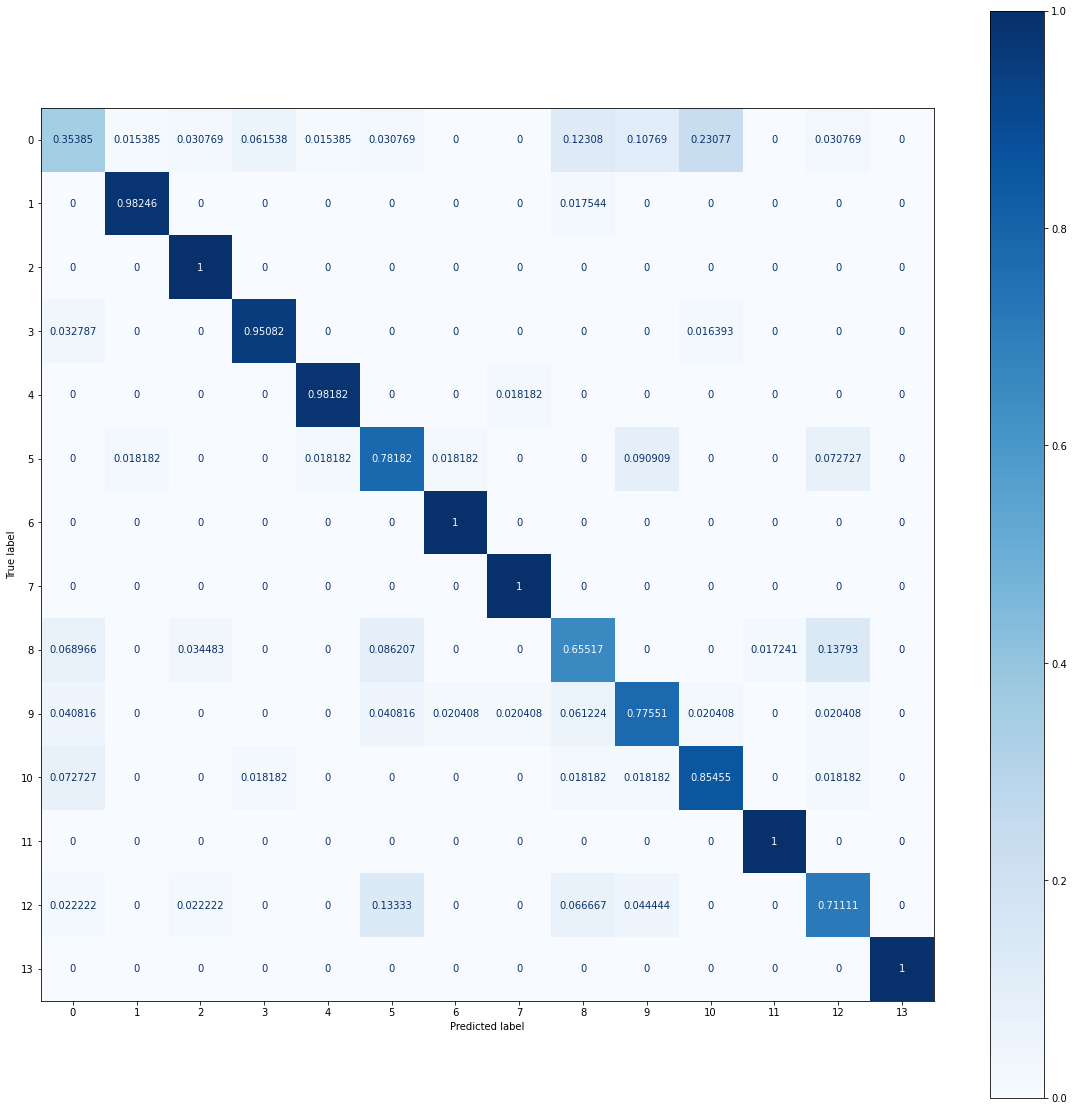

tiempo de ejecucion 50.616825580596924


,params,mean_test_accuracy,std_test_accuracy,mean_test_error,std_test_error,mean_test_precision,std_test_precision,rank_test_accuracy,rank_test_precision,mean_fit_time,std_fit_time,mean_score_time,std_score_time
0,"{'criterion': 'gini', 'n_estimators': 5}",0.659511,0.029942,0.340489,0.029942,0.669949,0.036642,14,13,0.092008,0.020588,0.011814,0.003273
1,"{'criterion': 'gini', 'n_estimators': 10}",0.740075,0.021522,0.259925,0.021522,0.735886,0.026507,12,12,0.177092,0.006681,0.012903,0.004012
2,"{'criterion': 'gini', 'n_estimators': 20}",0.805074,0.028038,0.194926,0.028038,0.801329,0.031943,9,9,0.346670,0.005576,0.015255,0.000950
3,"{'criterion': 'gini', 'n_estimators': 30}",0.825453,0.027928,0.174547,0.027928,0.819398,0.033351,7,7,0.526339,0.016077,0.022674,0.003288
4,"{'criterion': 'gini', 'n_estimators': 50}",0.832983,0.027293,0.167017,0.027293,0.829174,0.034867,5,5,0.912496,0.020061,0.031226,0.003798
5,"{'criterion': 'gini', 'n_estimators': 75}",0.842657,0.020267,0.157343,0.020267,0.843084,0.024627,3,2,1.366429,0.019044,0.044611,0.004441
6,"{'criterion': 'gini', 'n_estimators': 100}",0.849629,0.023977,0.150371,0.023977,0.846416,0.024883,1,1,1.856282,0.147612,0.057242,0.012387
7,"{'criterion': 'entropy', 'n_estimators': 5}",0.662745,0.024829,0.337255,0.024829,0.667102,0.031269,13,14,0.238936,0.006862,0.013017,0.004106
8,"{'criterion': 'entropy', 'n_estimators': 10}",0.753516,0.028145,0.246484,0.028145,0.754403,0.038550,11,11,0.465923,0.012544,0.009328,0.003597
9,"{'criterion': 'entropy', 'n_estimators': 20}",0.783543,0.026570,0.216457,0.026570,0.781254,0.030190,10,10,0.937223,0.011056,0.017647,0.004021


In [ ]:
param = {
          'n_estimators': [5,10,20,30,50,75,100],  
          'criterion': ['gini', 'entropy']
         
        } 
        
print("Random Forest")
model=RandomForestClassifier()
gs,RF,metricas=GridSearch(model,param,dataSet1)
dataFrame=pd.DataFrame(gs.cv_results_)
dataFrame[[ "params","mean_test_accuracy","std_test_accuracy","mean_test_error","std_test_error",
           "mean_test_precision","std_test_precision","rank_test_accuracy",
           "rank_test_precision","mean_fit_time","std_fit_time","mean_score_time","std_score_time"
           ]]

###Ada Boost Classifier

Ada Boost Classifier


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Pr

Mejor modelo entrando {'algorithm': 'SAMME', 'n_estimators': 100}
F1: 0.31960 (+/- 0.03636 
Exactitud: 0.37998 (+/- 0.06108) 
Accuracy: 0.34081 (+/- 0.03152) 
Error: 0.65919 (+/- 0.03152) 


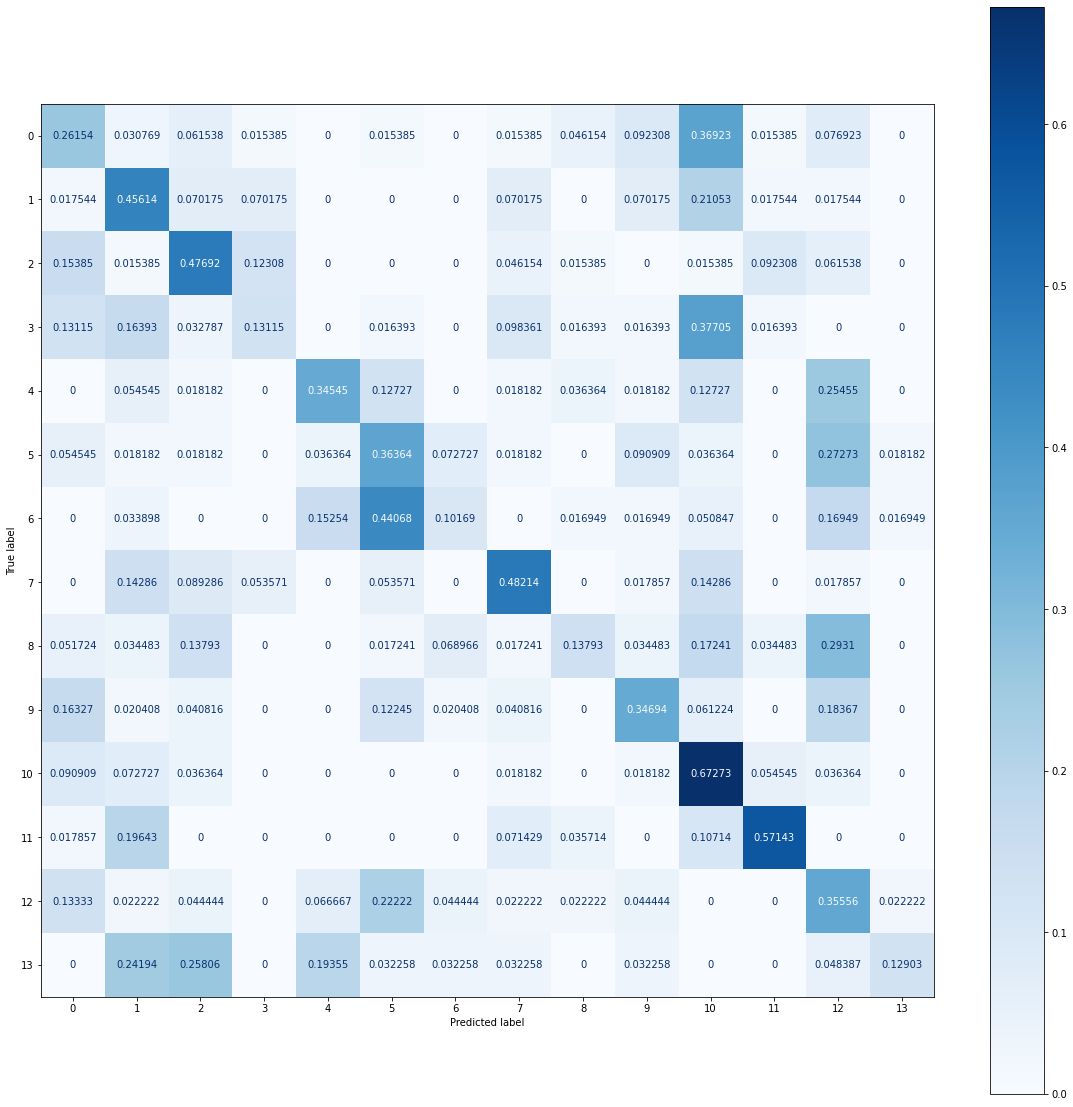

tiempo de ejecucion 32.55806493759155


,params,mean_test_accuracy,std_test_accuracy,mean_test_error,std_test_error,mean_test_precision,std_test_precision,rank_test_accuracy,rank_test_precision,mean_fit_time,std_fit_time,mean_score_time,std_score_time
0,"{'algorithm': 'SAMME', 'n_estimators': 5}",0.113309,0.013166,0.886691,0.013166,0.017034,0.001659,14,14,0.092977,0.018199,0.013229,0.005139
1,"{'algorithm': 'SAMME', 'n_estimators': 10}",0.159499,0.024119,0.840501,0.024119,0.066770,0.015396,13,13,0.194180,0.017321,0.014720,0.002503
2,"{'algorithm': 'SAMME', 'n_estimators': 20}",0.191731,0.028158,0.808269,0.028158,0.168647,0.045328,12,11,0.353048,0.008253,0.016453,0.002698
3,"{'algorithm': 'SAMME', 'n_estimators': 30}",0.227169,0.036664,0.772831,0.036664,0.229219,0.061302,8,7,0.532972,0.011302,0.020982,0.003393
4,"{'algorithm': 'SAMME', 'n_estimators': 50}",0.267989,0.031993,0.732011,0.031993,0.300354,0.061525,3,3,0.855720,0.091729,0.030862,0.006563
5,"{'algorithm': 'SAMME', 'n_estimators': 75}",0.290553,0.024621,0.709447,0.024621,0.331360,0.036934,2,2,1.230077,0.065877,0.035359,0.005718
6,"{'algorithm': 'SAMME', 'n_estimators': 100}",0.316345,0.031280,0.683655,0.031280,0.359514,0.034740,1,1,1.842991,0.052720,0.057591,0.010979
7,"{'algorithm': 'SAMME.R', 'n_estimators': 5}",0.207311,0.021985,0.792689,0.021985,0.141220,0.033775,11,12,0.110133,0.010376,0.016980,0.005388
8,"{'algorithm': 'SAMME.R', 'n_estimators': 10}",0.230384,0.023547,0.769616,0.023547,0.205413,0.032782,6,10,0.245284,0.009148,0.023281,0.005489
9,"{'algorithm': 'SAMME.R', 'n_estimators': 20}",0.245955,0.046493,0.754045,0.046493,0.231245,0.060865,4,6,0.446257,0.015433,0.028487,0.004442


In [ ]:
param = {
          'n_estimators': [5,10,20,30,50,75,100],  
          'algorithm': ['SAMME', 'SAMME.R']
         
        } 
        
print("Ada Boost Classifier")
model=AdaBoostClassifier()
gs,RF,metricas=GridSearch(model,param,dataSet1)
dataFrame=pd.DataFrame(gs.cv_results_)
dataFrame[[ "params","mean_test_accuracy","std_test_accuracy","mean_test_error","std_test_error",
           "mean_test_precision","std_test_precision","rank_test_accuracy",
           "rank_test_precision","mean_fit_time","std_fit_time","mean_score_time","std_score_time"
           ]]